In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

warnings.filterwarnings("ignore", category=UserWarning)

#### Nurodomas kelias į treniravimo ir testavimo duomenų rinkinius

In [3]:
train_dir = r"C:\Mokymu_medziaga\Mano projektas\My_project\dataset\train"
test_dir = r"C:\Mokymu_medziaga\Mano projektas\My_project\dataset\test"

#### Sukuriamas duomenų generatorius treniravimui ir testavimui

*Treniravimo duomenų generatorius su augmentacija atlieka keletą vaizdų apdorojimo ir didinimo veiksmų, kurie padeda modelio generalizacijai ir užkerta kelią perteklinei prisitaikymui (overfitting).*

In [4]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,                     # Normalizacija
    rotation_range=60,                  # Atsitiktinis nuotraukos sukimas nuo -60 iki +60 laipsnių
    width_shift_range=0.2,              # Atsitiktinis horizontalus perstūmimas (iki 30%)
    height_shift_range=0.2,             # Atsitiktinis vertikalus perstūmimas (iki 30%)
    shear_range=0.3,                  # Atsitiktinis įstrižainės iškraipymas
    zoom_range=0.3,                     # Atsitiktinis didinimas (iki 30%)
    # horizontal_flip=True,
    vertical_flip=True,                 # Atsitiktinis vertikalus apvertimas
    fill_mode="nearest",                # Užpildo strategija
    brightness_range=[0.9, 1.4],        # atsitiktinis šviesumo pakeitimas vaizduose 
                                        # (0.9 tai minimumo vertė, 1.3 tai maksimumo vertė)
    channel_shift_range=20.0            # Atsitiktinai keičiamas spalvų kanalų (raudono, žalio, mėlyno) intensyvą.
)

#### Sukuriamas duomenų generavimo objektas testavimo duomenims, tik su normalizacija

In [5]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)

In [6]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                        target_size=(224, 224), batch_size=32, class_mode="categorical")
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), 
                        batch_size=32, class_mode="categorical")

print("Klasės:", train_generator.class_indices)

Found 134 images belonging to 5 classes.


Found 39 images belonging to 5 classes.
Klasės: {'Azuolas': 0, 'Berzas': 1, 'Egle': 2, 'Juodalksnis': 3, 'Pusis': 4}


#### Atvaizduojami pirmieji 9 vaizdai iš treniravimo duomenų

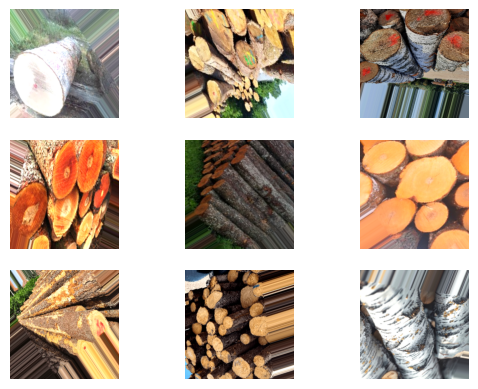

In [8]:
num_images = 9
batch = next(train_generator)

for i in range(min(num_images, len(batch[0]))):
    plt.subplot(3, 3, i + 1)
    img = batch[0][i]           # Paimame pirmus 9 vaizdus iš partijos
    plt.imshow(img)
    plt.axis("off")

#### Apibrėžiamas konvoliucinis (CNN) modelis naudojant Keras biblioteką

In [9]:
input_shape = (224, 224, 3)  # Vaizdo dydis yra 224x224 pikseliai su 3 spalvų kanalais (raudona, žalia, mėlyna)
num_classes = 5  # Skaičius nurodo, kiek skirtingų kategorijų modelis turi atpažinti

model = keras.Sequential(  # Modelis kuriamas sluoksniais, kurie dedami vienas po kito
    [
        keras.Input(shape=input_shape),  # Nustato, kokio dydžio duomenys bus paduodami į modelį
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        # Šis sluoksnis turi 32 filtrus (3x3 dydžio), kurie "ieško" svarbių detalių vaizde.
        # "relu" padeda pašalinti neigiamas reikšmes, todėl modelis tampa stabilesnis.

        layers.MaxPooling2D(pool_size=(2, 2)),
        # Šis sluoksnis sumažina vaizdo dydį. Jis paima kiekvieną 2x2 sritį ir pasirenka didžiausią reikšmę, 
        # taip sutaupydamas skaičiavimo galią.

        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # Kitas konvoliucinis sluoksnis su 64 filtrais, kuris ieško detalesnių ypatybių vaizde.

        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        # Trečias sluoksnis, kuris dar detaliau analizuoja vaizdą su 128 filtrais.

        # Pridedamas papildomas sluoksnis, geresniems rezultatams pasiekti
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),

        # Pirmi trys konvoliuciniai sluoksniai padeda modeliu išmokti sudėtingus vaizdo ypatumus:
        # pradžioje nustato paprastesnes struktūras (pvz., kraštus), o vėliau pereina prie detalesnių formų.

        layers.BatchNormalization(),  
        # per kiekvieną partiją apskaičiuoja duomenų vidurkį ir standartinį nuokrypį, o tada normalizuoja duomenis

        layers.GlobalAveragePooling2D(),  
        # sluoksnis, kuris sumažina parametrų skaičių.Apdoroja tik filtro vidurkius, o ne visus pikselius.

        layers.Dropout(0.5),
        # Atsitiktinai išjungia 50% neuronų, kad modelis nesimokytų per daug (overfitting) ir taptų stabilesnis.

        layers.Dense(512, activation="relu"),
        layers.Dense(256, activation="relu"),  # Antras tankus sluoksnis (papildomas sluoksnis)
        # Šis sluoksnis turi 512 neuronų ir padeda modeliu priimti sprendimą apie tai, kas yra vaizde.
        # Jis sujungia informaciją iš ankstesnių sluoksnių ir naudoja "relu" aktyvaciją.

        layers.Dense(num_classes, activation="softmax"),
        # Paskutinis sluoksnis, kuris suteikia galutinį rezultatą. 
        # "softmax" funkcija pateikia tikimybę kiekvienai klasei (pvz., ar tai yra medis A, medis B ir t.t.).
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 653,637 (2.49 MB)

 Trainable params: 653,125 (2.49 MB)

 Non-trainable params: 512 (2.00 KB)

*Paaiškinimas:*
- *conv2d_47 (Conv2D): conv2d_47: Tai sluoksnio pavadinimas. Skaičius 47 -  tai 47-tas konvoliucinis sluoksnis, kuris buvo sukurtas per šią Keras sesiją. Tai automatiškai priskirtas pavadinimas.*
- *Conv2D: Tai sluoksnio tipas - konvoliucinis sluoksnis, kuris naudojamas vaizdų apdorojimui. Jis padeda išgauti svarbias ypatybes (kraštus, tekstūras ir pan.) iš įvesties vaizdų.*
- *(None, 222, 222, 32): None: Tai pirmasis dimensijos dydis, kuris atitinka partijų (angl. batch) dydį. None reiškia, kad partijų dydis nėra fiksuotas ir gali būti bet koks.*
- *222, 222: Tai vaizdo aukštis ir plotis po apdorojimo šiame sluoksnyje*
- *32: Tai filtrų skaičius šiame konvoliuciniame sluoksnyje*

- *896:Tai parametrų skaičius šiame sluoksnyje. Apskaičiuojamas pagal formulę: (3×3×3)×32+32.*
*3 × 3: Tai filtro dydis (3x3 pikseliai).*
*3: Tai spalvų kanalų skaičius (RGB).*
*32: Filtrų skaičius. + 32: Tai papildomi parametrai (angl. bias), nes kiekvienam filtrui priskiriamas vienas papildomas parametras.*

- *MaxPooling2D sluoksnis sumažina vaizdų dydį perpus (dydis sumažėja nuo 222x222 iki 111x111), bet išlaiko 32 spalvų kanalus.*
*0 rodo, kad šiame sluoksnyje nėra jokių mokomų parametrų – tai tiesiog operacija, sumažinanti įvesties vaizdo dydį, nesumažinant svarbios informacijos.*

- *(None, 12, 12, 256): išėjimo formą iš BatchNormalization sluoksnio: None reiškia, kad tai yra partija (batch), kuri gali turėti įvairų skaičių pavyzdžių.*
*12x12 reiškia, kad vaizdas po konvoliucinių ir poolingo sluoksnių yra sumažintas iki 12x12 dydžio.*
*256 nurodo, kad kiekvienas iš šių 12x12 pikselių turi 256 kanalus (filtrus), kuriuos modelis naudoja analizuoti vaizdo ypatybes.*

- *GlobalAveragePooling2D sluoksnio išėjimo dydis yra 256. Tai nurodo, kad po visų konvoliucinių ir pooling sluoksnių liko 256 kanalai, kuriuose pateikiama sumažinta informacija apie vaizdą.*

#### Optimizatoriaus ir klaidos funkcijos nustatymas modelyje

In [10]:
optimizer = Adam(learning_rate=0.0001)  
# Learning rate- (mokymosi greitis) nustato žingsnio dydį, kuriuo modelis „mokosi“.
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# categorical_crossentropy) matuoja skirtumą tarp tikrų ir modelio prognozuotų kategorijų.
# Metrika (accuracy) stebi modelio tikslumą treniruotės metu, tai yra, kiek procentų prognozių buvo teisingos.

#### Modelio treniravimas su duomenų generatoriais ir validacijos žingsniais

In [11]:
steps_per_epoch = max(1, train_generator.samples // train_generator.batch_size)  
# nustato, kiek treniravimo partijų bus apdorota per vieną epochos treniravimą.
validation_steps = max(1, test_generator.samples // test_generator.batch_size)  
# nustato, kiek testavimo partijų bus apdorota per vieną epochos testavimą.

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,    
    # nurodo, kiek žingsnių modelis atliks per vieną epochą
    epochs=25,                          
    # kiek kartų visas treniravimo duomenų rinkinys bus praeitas per modelį.
    verbose=1,                          # nustato, kokio lygio informacija bus rodoma 
    validation_data=test_generator,     # testavimo duomenų generatorius, kurio metu modelis 
                                        #  bus tikrinamas po kiekvienos epochos.
    validation_steps=validation_steps   
    # Nustato, kiek žingsnių atlikti per testavimo (validacijos) etapą.
)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step - accuracy: 0.2156 - loss: 1.6101 - val_accuracy: 0.2812 - val_loss: 1.6037
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3333 - loss: 1.5682 - val_accuracy: 0.1429 - val_loss: 1.6044
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.2728 - loss: 1.5596
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 264ms/step - accuracy: 0.2188 - loss: 1.5679 - val_accuracy: 0.1875 - val_loss: 1.6030
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3250 - loss: 1.4946 - val_accuracy: 0.5714 - val_loss: 1.5696
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3750 - loss: 1.5337
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.3853 - loss: 1.4602 - val_accuracy: 0.4688 - val_loss: 1.5850
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3438 - loss: 1.4787 - val_accuracy: 0.4286 - val_loss: 1.6151
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.3297 - loss: 1.4680
Epoch 10/

#### Modelio įvertinimas testavimo duomenyse

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Modelio tikslumas: {test_accuracy}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.4915 - loss: 1.5645
Modelio tikslumas: 0.4871794879436493


#### Išsaugomas sukurtas modelis į failą, kad vėliau galėtumėte jį panaudoti

In [13]:
FILES_PATH = Path(r"C:\Mokymu_medziaga\Mano projektas\My_project\models")
model.save(FILES_PATH / "my_foto_model.keras")

#### Tikslumo ir nuostolio pokyčių per epochas vizualizacija

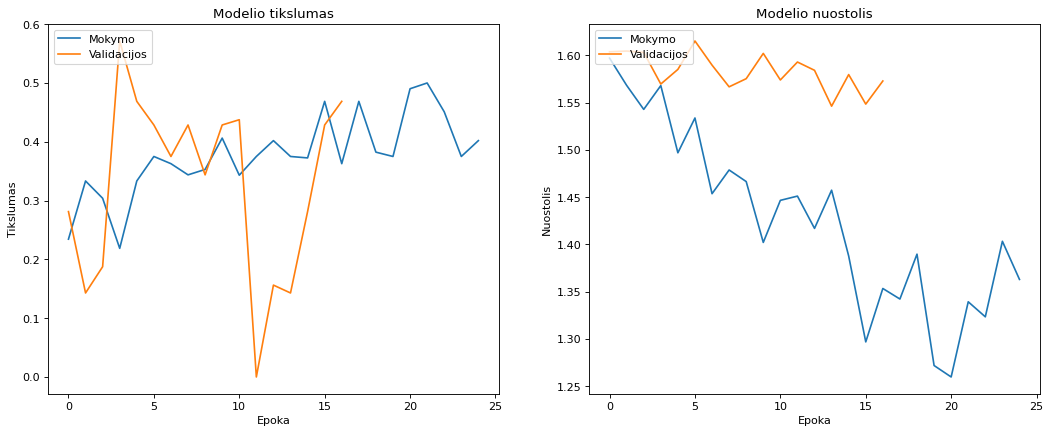

In [14]:

def plot_accuracy_loss(history):
    """
    Plotas modelio tikslumo ir praradimo kreivės.

    Args:
        history (History): Keras History objektas, kurio atributai 'history'
                            turi reikšmes 'accuracy', 'val_accuracy', 
                            'loss', 'val_loss' mokymo proceso metu.

    Returns:
        None: Funkcija tik grafinėse diagramose rodo tikslumo ir praradimo pokyčius.
    """
    plt.figure(figsize=(16, 6), dpi=80)

    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Modelio tikslumas")
    plt.ylabel("Tikslumas")
    plt.xlabel("Epoka")
    plt.legend(["Mokymo", "Validacijos"], loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Modelio nuostolis")
    plt.ylabel("Nuostolis")
    plt.xlabel("Epoka")
    plt.legend(["Mokymo", "Validacijos"], loc="upper left")

    plt.show()

plot_accuracy_loss(history)

- *Tikslumo (Accuracy) vizualizacija:*

*Mokymo tikslumas (accuracy): Parodo, kaip gerai modelis atpažįsta vaizdus treniravimo duomenų rinkinyje per kiekvieną epochą. Jei mokymo tikslumas didėja, tai rodo, kad modelis gerėja mokantis iš treniravimo duomenų.*

*Validacijos tikslumas (val_accuracy): Parodo, kaip gerai modelis atpažįsta vaizdus nepažįstamuose duomenyse, kurie buvo naudojami kaip validacija. Tai svarbu, nes tai rodo, kaip modelis galės veikti realiame pasaulyje su naujais, nematytais duomenimis.*

- *Nuostolių (Loss) vizualizacija:*

*Mokymo nuostolis (loss): Rodo, kaip klaida modelio prognozėse mažėja per epochas treniravimo duomenyse.*

*Validacijos nuostolis (val_loss): Tai klaida modelio prognozėse su validacijos duomenimis.*

In [15]:
true_labels = test_generator.classes  # tikros klasės
true_labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4])

In [29]:
test_generator_pred = model.predict(test_generator)  # modelio prognozuotos klasės
predicted_labels = np.argmax(test_generator_pred, axis=1)
predicted_labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step


array([2, 2, 1, 2, 1, 4, 2, 2, 1, 1, 2, 2, 2, 4, 2, 2, 1, 4, 1, 2, 1, 4,
       1, 4, 1, 1, 4, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1], dtype=int64)

In [30]:
cm = confusion_matrix(true_labels, predicted_labels)

#### Klaidų matrica

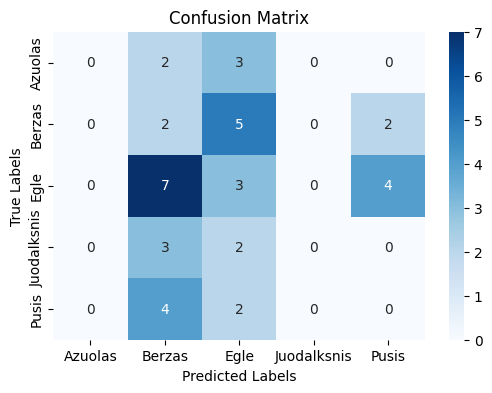

In [31]:
class_names = ["Azuolas", "Berzas", "Egle", "Juodalksnis", "Pusis"]

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()

#### Klaidingai klasifikuotų vaizdų analizė

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step


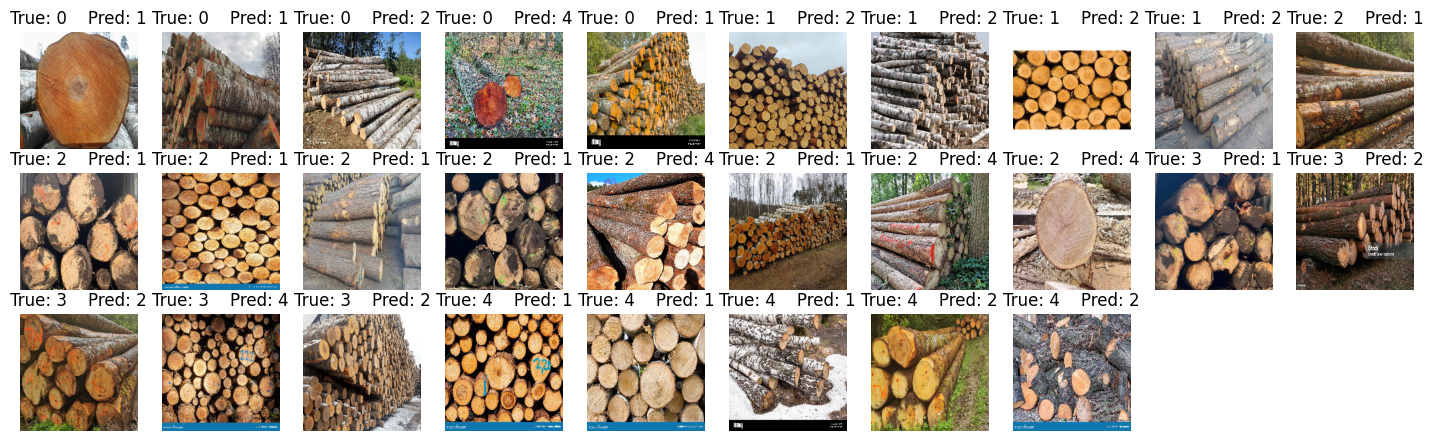

In [19]:
true_labels = test_generator.classes
predicted_labels = np.argmax(model.predict(test_generator), axis=1)

misclassified_indices = [
    i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels, strict=False))
    if true != pred
]

plt.figure(figsize=(18, 18))
size = 10  # Nustatyti norimą atvaizdų kiekį (šiuo atveju 10x10)

for i, index in enumerate(misclassified_indices[:size * size]):
    batch_index = index // test_generator.batch_size  # Indeksas, kurioje partijų dalyje yra klaidingas vaizdas
    batch_images, _ = test_generator[batch_index]  # Gaunama partija iš test_generator pagal batch_index

    img = batch_images[index % test_generator.batch_size]       # Pasirinkti klaidingą atvaizdą atsitiktinai

    plt.subplot(size, size, i + 1)
    plt.imshow(img, cmap="gray")
    plt.title(f"True: {true_labels[index]}    Pred: {predicted_labels[index]}")
    plt.axis("off")

plt.show()

####  Išsaugoto modelio įkėlimas ir modelio bandymas su nauja foto (klasės spėjimas)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


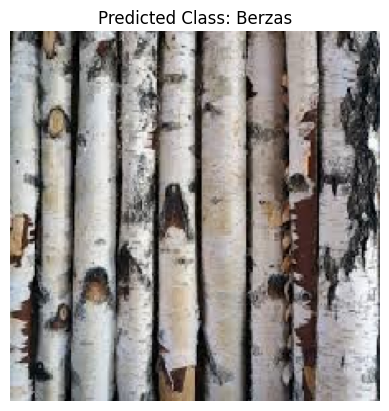

In [26]:
model = load_model(FILES_PATH / "my_foto_model.keras")
img_path = r"C:\Mokymu_medziaga\Mano projektas\My_project\dataset\test\example7.jpg"

class_names = {"Azuolas": 0, "Berzas": 1, "Egle": 2, "Juodalksnis": 3, "Pusis": 4}

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

prediction = model.predict(img_array)
predicted_class = np.argmax(prediction, axis=1)[0]

class_names = {0: "Azuolas", 1: "Berzas", 2: "Egle", 3: "Juodalksnis", 4: "Pusis"}

predicted_class_label = class_names[predicted_class]

plt.imshow(img)
plt.title(f"Predicted Class: {predicted_class_label}")
plt.axis("off")
plt.show()

Pavyzdžių kurie naudojami klases nustatymui/prognozavimui, tikrosios reikšmės:

exmple5 - berzas
example7 - berzas
example8 - berzas
example9 - berzas
example22 - azuolas
example1 - pusis
example2 - pusis
example3 - egle
example4 - egle
example24 - egle
example6 - egle
example10 - berzas

Išvados:

Modelio tikslumas: Modelis, šiuo metu dar nėra pasiekęs geriausio prognozavimo tikslumo, sunkiai identifikuoja kai kurias klases. Tai rodo, kad modelis nesugeba tinkamai išmokti atskirti subtilius skirtumus tarp klasių.
Tai rodo galimas problemas su klasifikavimo balanso trūkumu arba duomenų įvairovės trūkumu, kuris gali lemti tokią klaidą.

Tobulinimo poreikis: Pagal šiuo metu gautus rezultatus, modelis yra nepakankamai apmokytas ir reikia įgyvendinti tolesnius tobulinimo žingsnius. Tai gali apimti tiek duomenų rinkimo, tiek modelio architektūros, tiek hiperparametrų optimizavimo koregavimą.

Hiperparametrų optimizavimas: Modelio tikslumas galėtų pagerėti atlikus hiperparametrų optimizavimą. Tai apima tinkamų mokymosi greičių, sluoksnių skaičiaus, aktyvavimo funkcijų ir kitų parametrų pasirinkimą, kurie gali padėti geriau išmokyti modelį ir pasiekti geresnius rezultatus.